In [1]:
!pip install wordcloud

In [2]:
!pip install xgboost 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from xgboost import XGBClassifier
from IPython.display import display
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
url = 'https://raw.githubusercontent.com/allatifatulmuharomiah/Lazada-Review-Sentiment-Analysis/master/Data/20191002-reviews.csv'
df = pd.read_csv(url)
display(df.head())

print(df.shape)

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02


(203787, 15)


In [5]:
print(f"Feature names: {df.columns.values}")

Feature names: ['itemId' 'category' 'name' 'rating' 'originalRating' 'reviewTitle'
 'reviewContent' 'likeCount' 'upVotes' 'downVotes' 'helpful'
 'relevanceScore' 'boughtDate' 'clientType' 'retrievedDate']


In [6]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(['originalRating', 'reviewTitle', 'likeCount', 'upVotes', 'downVotes', 'helpful', 'relevanceScore', 'boughtDate', 'clientType', 'retrievedDate'], axis=1)

In [7]:
print(f"Feature names: {df.columns.values}")
display(df.head())

Feature names: ['itemId' 'category' 'name' 'rating' 'reviewContent']


,itemId,category,name,rating,reviewContent
0,100002528,beli-harddisk-eksternal,Kamal U.,5,bagus mantap dah sesui pesanan
1,100002528,beli-harddisk-eksternal,yofanca m.,4,"Bagus, sesuai foto"
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,okkkkk mantaaaaaaapppp ... goood
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,bagus sesuai
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN


In [8]:
# Memeriksa nilai null pada data
null_values = df.isnull().sum()
print(null_values)


itemId               0
category             0
name                 0
rating               0
reviewContent    96758
dtype: int64


In [9]:
# Menghapus baris dengan nilai null pada kolom 'reviewContent'
df.dropna(subset=['reviewContent'], inplace=True)

null_values = df.isnull().sum()
print(null_values)
print(df.shape)

itemId           0
category         0
name             0
rating           0
reviewContent    0
dtype: int64
(107029, 5)


In [10]:
df['length'] = df['reviewContent'].apply(len)

display(df.head())

,itemId,category,name,rating,reviewContent,length
0,100002528,beli-harddisk-eksternal,Kamal U.,5,bagus mantap dah sesui pesanan,31
1,100002528,beli-harddisk-eksternal,yofanca m.,4,"Bagus, sesuai foto",18
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,okkkkk mantaaaaaaapppp ... goood,32
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,bagus sesuai,12
7,100002528,beli-harddisk-eksternal,nurfarida,1,bima,4


In [11]:
print(df.dtypes)

itemId            int64
category         object
name             object
rating            int64
reviewContent    object
length            int64
dtype: object


# **Analyzing 'rating' column**

In [12]:
len(df)

107029

In [13]:
print(f"Rating value count: \n{df['rating'].value_counts()}")

Rating value count: 
5    82896
4    10626
1     6951
3     4372
2     2184
Name: rating, dtype: int64


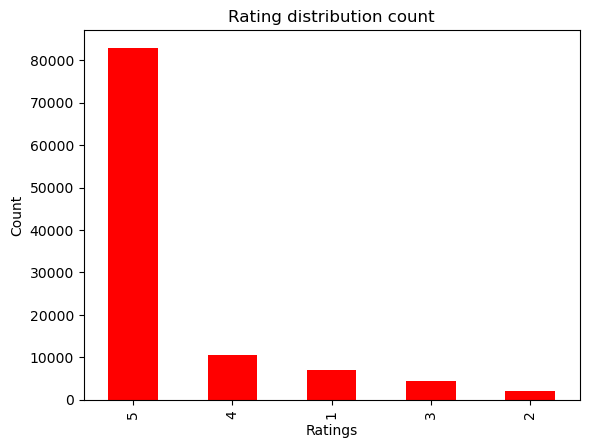

In [14]:
df['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [15]:
print(f"Rating value count - percentage distribution: \n{round(df['rating'].value_counts()/df.shape[0]*100,2)}")

Rating value count - percentage distribution: 
5    77.45
4     9.93
1     6.49
3     4.08
2     2.04
Name: rating, dtype: float64


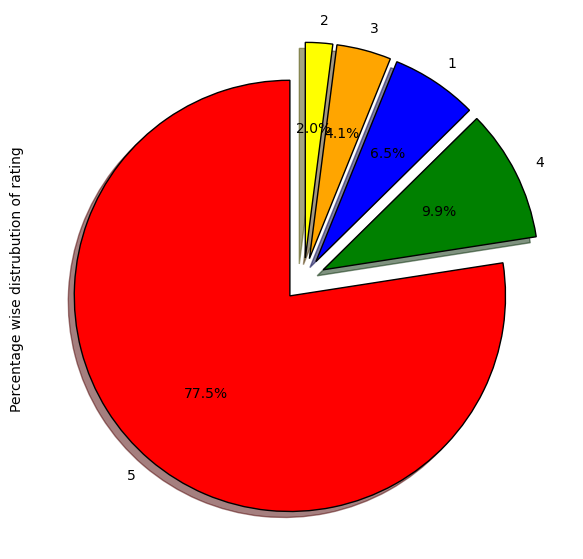

In [16]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['rating'].value_counts()/df.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

# **Analyzing 'category' column**

In [17]:
print(f"Category value count: \n{df['category'].value_counts()}")

Category value count: 
beli-harddisk-eksternal    42039
jual-flash-drives          32738
beli-smart-tv              17233
shop-televisi-digital      11934
beli-laptop                 3085
Name: category, dtype: int64


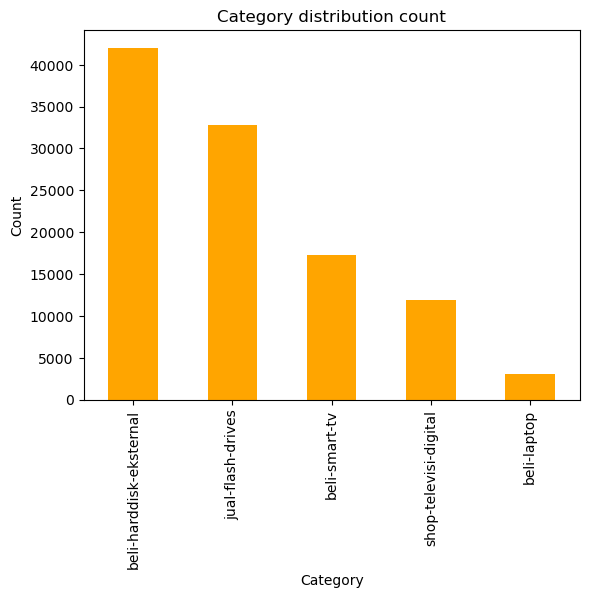

In [18]:
df['category'].value_counts().plot.bar(color = 'orange')
plt.title('Category distribution count')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [19]:
print(f"Category value count - percentage distribution: \n{round(df['category'].value_counts()/df.shape[0]*100,2)}")

Category value count - percentage distribution: 
beli-harddisk-eksternal    39.28
jual-flash-drives          30.59
beli-smart-tv              16.10
shop-televisi-digital      11.15
beli-laptop                 2.88
Name: category, dtype: float64


# **Analyzing 'reviewContent' column**

In [20]:
def categorize_rating(rating):
    if rating in [3, 4, 5]:
        return '1'
    else:
        return '0'

df['sentiment'] = df['rating'].apply(categorize_rating)
# Menampilkan DataFrame setelah preprocessing
display(df.head())


,itemId,category,name,rating,reviewContent,length,sentiment
0,100002528,beli-harddisk-eksternal,Kamal U.,5,bagus mantap dah sesui pesanan,31,1
1,100002528,beli-harddisk-eksternal,yofanca m.,4,"Bagus, sesuai foto",18,1
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,okkkkk mantaaaaaaapppp ... goood,32,1
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,bagus sesuai,12,1
7,100002528,beli-harddisk-eksternal,nurfarida,1,bima,4,0


In [21]:
sentiment_counts = df['sentiment'].value_counts()
print(f"Jumlah Sentimen Negatif dan Positif:\n{sentiment_counts}")


Jumlah Sentimen Negatif dan Positif:
1    97894
0     9135
Name: sentiment, dtype: int64


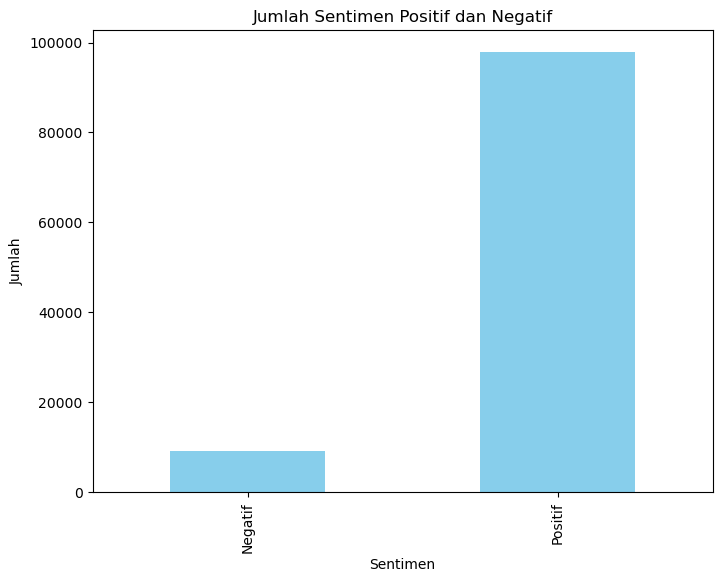

In [22]:
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Jumlah Sentimen Positif dan Negatif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.show()

In [23]:
indonesian_stopwords = [
    'yang', 'untuk', 'dari', 'dengan', 'akan', 'pada', 'ini', 'itu', 'dan', 'di', 'ke', 'dalam', 'adalah', 
    'tidak', 'saya', 'dia', 'kita', 'kami', 'anda', 'mereka', 'apa', 'bagaimana', 'mengapa', 'siapa', 
    'bukan', 'ada', 'juga', 'sudah', 'belum', 'lebih', 'kurang', 'hanya', 'bisa', 'dapat', 'harus', 
    'banyak', 'sedikit', 'seperti', 'agar', 'tetapi', 'kalau', 'jadi', 'karena', 'oleh', 'menjadi', 
    'apakah', 'saat', 'setelah', 'sebelum', 'itu', 'tersebut', 'lagi', 'yg', ''
]


In [24]:
stopwords = set(indonesian_stopwords)

# Kombinasi semua review
reviews = " ".join([review for review in df['reviewContent']])


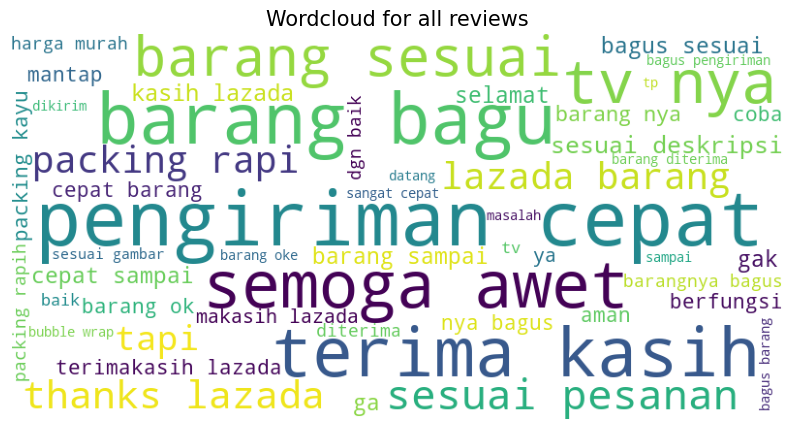

In [25]:
# Membuat dan menampilkan WordCloud untuk semua review
wc = WordCloud(background_color='white', max_words=50, stopwords=stopwords, width=800, height=400)
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=15)
plt.axis('off')
plt.show()

In [26]:
# Gabungkan semua review untuk setiap kategori dan pisahkan menjadi kata-kata individual
neg_reviews = " ".join([review for review in df[df['sentiment'] == '0']['reviewContent']])
pos_reviews = " ".join([review for review in df[df['sentiment'] == '1']['reviewContent']])

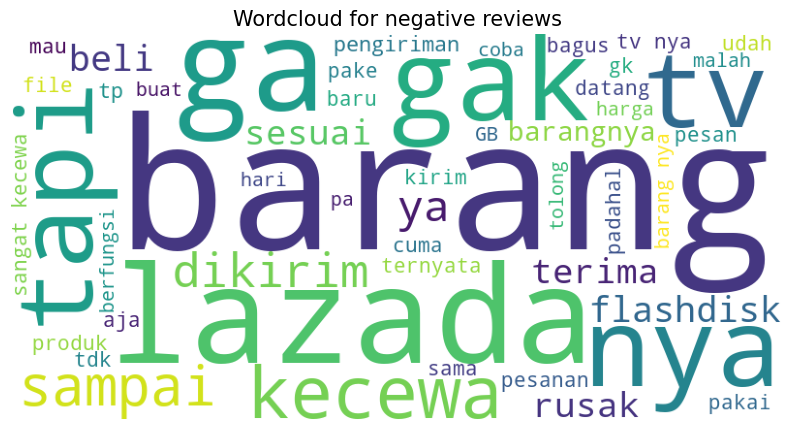

In [27]:
# Membuat WordCloud untuk review negatif
wc_neg = WordCloud(background_color='white', max_words=50, stopwords=stopwords, width=800, height=400)
plt.figure(figsize=(10, 10))
plt.imshow(wc_neg.generate(neg_reviews))
plt.title('Wordcloud for negative reviews', fontsize=15)
plt.axis('off')
plt.show()

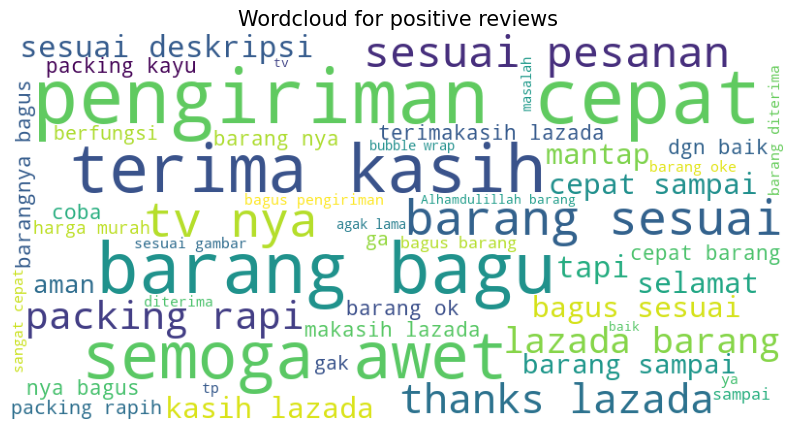

In [28]:
# Membuat WordCloud untuk review positif
wc_pos = WordCloud(background_color='white', max_words=50, stopwords=stopwords, width=800, height=400)
plt.figure(figsize=(10, 10))
plt.imshow(wc_pos.generate(pos_reviews))
plt.title('Wordcloud for positive reviews', fontsize=15)
plt.axis('off')
plt.show()

# **Preprocessing dan Modelling**

In [29]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['reviewContent'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [30]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['sentiment'].values

In [31]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [32]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (107029, 2500)
y shape: (107029,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

In [35]:
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (74920, 2500)
y train: (74920,)
X test: (32109, 2500)
y test: (32109,)


In [36]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 23
X test max value: 15


In [37]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [38]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [39]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [40]:
# XGBoost
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9599973304858516
Testing Accuracy : 0.9521940888847363


In [42]:
y_preds = model_xgb.predict(X_test)

In [43]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 1625  1106]
 [  548 28830]]


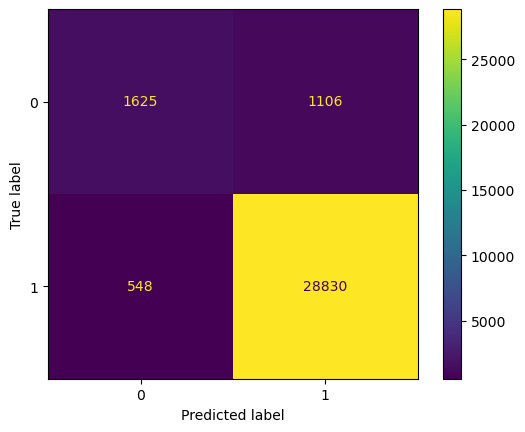

In [44]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [45]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [46]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [47]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9978510411105179
Testing Accuracy : 0.9855180790432589


In [48]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [49]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

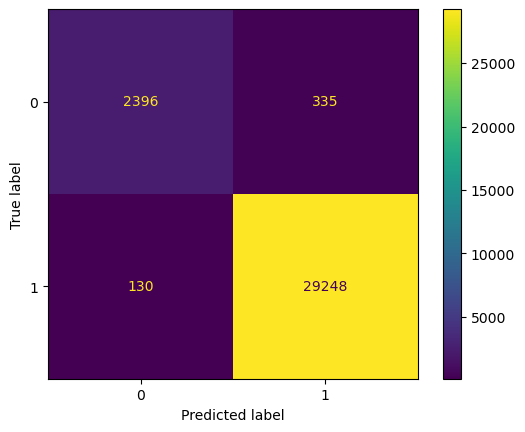

In [50]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [51]:
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))